In [8]:
import numpy as np
import os, glob
import pyfits
import dicom
import matplotlib.pyplot as plt
import tensorflow as tf
import tflearn
import sklearn, sklearn.preprocessing
from skimage.restoration import denoise_nl_means
import scipy
%matplotlib inline

## Import and preprocessing

In [49]:
def importHeartData(calmFile, stressFile, resize):
    """
    Import heart data and extract the pixel array.
    Concatenate and return stress file and calm file.
    If resize == 1 resize zoom image to ~[34,34,34].
    """
    calmTmp = dicom.read_file(calmFile).pixel_array
    stressTmp = dicom.read_file(stressFile).pixel_array
    
    calmTmp = cropHeart(calmTmp)
    stressTmp = cropHeart(stressTmp)

    # Pad the 2d slices with zeros so that they are all the same size
    zeroArr0 = np.zeros((34,34,34))
    zeroArr1 = np.zeros((34,34,34))
    
    if resize == 1:      
        # Resize the input data
        calmRatio = 34.0/np.amax(calmTmp.shape)
        stressRatio = 34.0/np.amax(stressTmp.shape)

        calmTmp = scipy.ndimage.interpolation.zoom(calmTmp, (calmRatio))
        stressTmp = scipy.ndimage.interpolation.zoom(stressTmp, (stressRatio))

        zeroArr0[:calmTmp.shape[0],:calmTmp.shape[1],:calmTmp.shape[2]] = calmTmp
        zeroArr1[:stressTmp.shape[0],:stressTmp.shape[1],:stressTmp.shape[2]] = stressTmp    
        
        # Normalise and clean
        zeroArr0 = normalise(zeroArr0)
        zeroArr1 = normalise(zeroArr1)
        #zeroArr0 = denoise_nl_means(zeroArr0, h=0.1, multichannel=False)
        #zeroArr1 = denoise_nl_means(zeroArr1, h=0.1, multichannel=False)
        
    else:
        zeroArr0[:calmTmp.shape[0],:calmTmp.shape[1],:calmTmp.shape[2]] = calmTmp
        zeroArr1[:stressTmp.shape[0],:stressTmp.shape[1],:stressTmp.shape[2]] = stressTmp

    catOut = np.moveaxis(np.array([zeroArr0, zeroArr1]), 0, -1)
    return catOut

def importDir(parentDir):
    """
    Scan though directories in parent directory; look for dirs labelled 
    STRESS* or REST* in the imediate subsirs and import any dcm files in them.
    Return a dataFile of the concatenated stress and calm *.dcm files.
    """
    tmplst = []
    for dirs in os.listdir(parentDir):
        cwdStress = glob.glob(parentDir+"/"+dirs+"/STRESS*/*.dcm")
        cwdCalm = glob.glob(parentDir+"/"+dirs+"/REST*/*.dcm")
        tmplst.append(importHeartData(cwdCalm[0], cwdStress[0], 1))
        
    dataFile = np.array(tmplst)
    return dataFile

def cropHeart(inp):
    """
    Crop the heart so that all the padding is done away with.
    Output cropped heart.
    """
    # argwhere will give you the coordinates of every non-zero point
    true_points = np.argwhere(inp)
    # take the smallest points and use them as the top left of your crop
    top_left = true_points.min(axis=0)
    # take the largest points and use them as the bottom right of your crop
    bottom_right = true_points.max(axis=0)
    out = inp[top_left[0]:bottom_right[0]+1,  # plus 1 because slice isn't
          top_left[1]:bottom_right[1]+1,   # inclusive
          top_left[2]:bottom_right[2]+1]  
    return out

def normalise(inData):
    """
    Normalise 3D array.
    """
    inDataAbs = np.fabs(inData)
    inDataMax = np.amax(inData)
    normalisedData = inDataAbs/inDataMax
    return normalisedData

In [50]:
# Do data import
normDir = "./data/nlst"
normDat = importDir(normDir)
abDir = "./data/rlst"
abDat = importDir(abDir)
inData = np.concatenate([normDat[:abDat.shape[0]], abDat]) # Normal and abnormal data same number of ppts

# Do labelling
normLab = np.zeros(normDat.shape[0])[:abDat.shape[0]]
abLab = np.ones(abDat.shape[0])
labels = np.concatenate([normLab, abLab])
    
# Mutual shuffle
shufData, shufLab = sklearn.utils.shuffle(inData, labels, random_state=1)
shufData = np.reshape(shufData,(-1,34,34,34,2))
shufLabOH = np.eye(2)[labels.astype(int)] # One hot encode

(58, 34, 34, 34, 2)
(34, 34, 34)


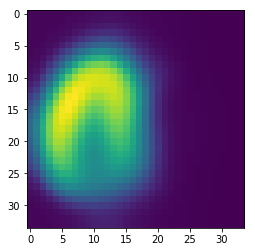

In [66]:
print(shufData.shape)
im = denoise_nl_means(shufData[5,...,0], h=0.1, multichannel=False)
plt.imshow(im[15])

## Neural net

In [54]:
sess = tf.InteractiveSession()
tf.reset_default_graph()
tflearn.initializations.normal()

# Input layer:
net = tflearn.layers.core.input_data(shape=[None, 34, 34, 34, 2])

# First layer:
net = tflearn.layers.conv.conv_3d(net, 8, [5,5,5],  activation="leaky_relu")
net = tflearn.layers.conv.max_pool_3d(net, 2, strides=2)

# Second layer:
net = tflearn.layers.conv.conv_3d(net, 16, [5,5,5], activation="leaky_relu")
net = tflearn.layers.conv.max_pool_3d(net, 2, strides=2)

# Fully connected layer
net = tflearn.layers.core.fully_connected(net, 1024, regularizer="L2", weight_decay=0.001, activation="leaky_relu")
net = tflearn.layers.core.fully_connected(net, 1024, regularizer="L2", weight_decay=0.001, activation="leaky_relu")

# Dropout layer:
net = tflearn.layers.core.dropout(net, keep_prob=0.5)

# Output layer:
net = tflearn.layers.core.fully_connected(net, 2, activation="softmax")

net = tflearn.layers.estimator.regression(net, optimizer='adam', learning_rate=0.01, loss='categorical_crossentropy')

model = tflearn.DNN(net, tensorboard_verbose=0)
model.fit(shufData, shufLabOH, batch_size=10, n_epoch=50, show_metric=True, validation_set=0.1)

Training Step: 43  | total loss: 12.22161 | time: 4.566s
| Adam | epoch: 008 | loss: 12.22161 - acc: 0.4692 -- iter: 10/52


KeyboardInterrupt: 